Before adversarial training, Note that typically, robustness to adversarial examples can sometimes reduce accuracy on clean data.

#**Dynamic Adversarial Image Generation vs. Batch Pre-computed Adversarial Image Generation: What's better for defense?**

##**Dynamic Generation (On-the-Fly)**

- Adaptivity:  Generating adversarial examples on the fly means that the adversaries are tailored to the current state of your model. As the model learns and evolves, the adversarial examples are continuously updated, keeping the model challenged with the most relevant "mistakes." This is analogous to practicing with a sparring partner who adapts to your skill level in real time.

- Compute Cost:
The downside is that dynamically generating adversarial examples can significantly increase the computational load during training. It means more forward and backward passes per training step, which could slow down your training.



##**Pre-Generation (Batch Pre-Computed)**

- Efficiency:
    Pre-generating adversarial examples means you compute them once and then reuse them during training. This can speed up your training loop because you're not doing the extra computations for each training step.

-  Static Nature:
    However, pre-generated examples may become less effective as the model improves. The model might eventually "overfit" to these specific adversarial examples rather than becoming more robust in general.


In [ ]:
### FGSM and PGD as functions for easy use ###

# Normalisation params
mean= 0.5
std=0.5
min_val = (0.0 - mean) / std  # = -1.0
max_val = (1.0 - mean) / std  # = 1.0


def fgsm_attack(image, label, model, epsilonFGSM):
  model.zero_grad() 
  epsilonFGSM_scaled = epsilonFGSM / std
  image.requires_grad = True
  output = model(image)
  lossfn = torch.nn.CrossEntropyLoss()
  loss = lossfn(output, label)
  loss.backward()
  grad = image.grad
  perturbation = epsilonFGSM_scaled * grad.sign()
  adv_image = torch.clamp((image + perturbation),min_val,max_val)
  return adv_image

def pgd_attack(model, image, label, epsilonPGD, alpha, num_of_steps, random_start):
    epsilonPGD_scaled = epsilonPGD / std
    alpha_scaled = alpha / std
    if random_start:
      noise = torch.empty_like(image).uniform_(-epsilonPGD_scaled,epsilonPGD_scaled)
      adv_image = image + noise
    else:
      adv_image = image.clone()

    for _ in range(num_of_steps):
      adv_image.requires_grad = True
      output = model(adv_image)
      lossfn = nn.CrossEntropyLoss()
      loss = lossfn(output, label)
      loss.backward()
      grad = adv_image.grad
      adv_image = adv_image + (alpha_scaled * grad.sign())
      perturbation = torch.clamp(adv_image - image, -epsilonPGD_scaled, epsilonPGD_scaled)
      adv_image = (torch.clamp((image + perturbation), min_val, max_val)).detach()
      adv_image.grad = None


    return adv_image




In [ ]:
# Load the MNIST dataset again
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader


# Splitting 40% clean, 30% fgsm, 30% pgd for the train set


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset  = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset   = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.12MB/s]


In [ ]:
### Params

#FGSM
epsilonFGSM = 0.5
# e = 0.4 to 0.5 seems like a good middle ground where the adversarial images dont get too distorted
"""
Training with a higher epsilon (e.g., ε = 0.6 or more) is possible, but it introduces critical trade-offs and challenges that often make it counterproductive.
-- Overly Large Perturbations Degrade Training
    Adversarial examples lose semantic meaning: When ε is too large (e.g., ε = 0.6 in pixel space for MNIST), perturbations dominate the original image. Digits become unrecognizable even to humans, turning into noise.
        Example: A "3" perturbed with ε = 0.6 may look like random scribbles.
        Result: The model learns to classify noise, not robust features.
    Generalization fails: The model overfits to extreme adversarial examples and performs poorly on clean or moderately perturbed data.

"""

#PGD
num_of_steps = 40
random_start = True # boolean to do random initialization
epsilonPGD = 0.3
alpha = epsilonPGD / num_of_steps #step size

In [ ]:
### Load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#Defining the CNN that we'll train to be robust against attacks
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 64 * 7 * 7)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [ ]:
import random

# Defining params
# Define weights for each mode: 1 = clean, 2 = FGSM, 3 = PGD
weights = [0.4, 0.3, 0.3]  # Clean: 40%, FGSM: 30%, PGD: 30%
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
  model.train()
  running_loss = 0.0

  for images, labels in trainloader:
       # Move batch to the correct device
       images, labels = images.to(device), labels.to(device)

       # Randomly choose a mode based on weighted probabilities
       mode = random.choices(population=[1, 2, 3], weights=weights, k=1)[0]

       if mode == 1:
          # Use clean images
          input_images = images
       elif mode == 2:
          # Generate FGSM adversarial examples
          input_images = fgsm_attack(images, labels, model, epsilonFGSM)
       elif mode == 3:
          # Generate PGD adversarial examples
          input_images = pgd_attack(model, images, labels, epsilonPGD, alpha, num_of_steps, random_start)
          # def pgd_attack(model, image, label, epsilon, alpha, num_of_steps, random_start):


        # Forward pass with the selected batch
       optimizer.zero_grad()
       outputs = model(input_images)
       loss = criterion(outputs, labels)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

# Save model
torch.save(model.state_dict(), "mnist_cnn_adversarially_trained.pth")
print("Model training complete. Saved as mnist_cnn_adversarially_trained.pth")



Epoch 1, Loss: 0.9675451293786261
Epoch 2, Loss: 0.44376236996424795
Epoch 3, Loss: 0.3122341380685941
Epoch 4, Loss: 0.2822312189187648
Epoch 5, Loss: 0.22592634072195666
Model training complete. Saved as mnist_cnn_adversarially_trained.pth


In [ ]:
# testing accuracy on vanilla images
correct = 0
total = 0

with torch.no_grad():
  for images, labels in testloader:
    # Move images and labels to the same device as the model
    images, labels = images.to(device), labels.to(device)  # Added this line
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the vanilla test set: {accuracy:.2f}%')

Accuracy of the model on the vanilla test set: 98.22%


In [ ]:
#Loading the model

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the same CNN model structure as before
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = CNN()

# Load the saved model state
model.load_state_dict(torch.load('/content/mnist_cnn_adversarially_trained.pth', map_location=torch.device('cpu')))
model.eval()  # Set model to evaluation mode

print("Model successfully loaded!")

Model successfully loaded!


In [ ]:
# Accuracy test on fgsm adversarial dataset
# Single for loop for all epsilons

from torch.utils.data import TensorDataset, DataLoader

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []

for epsilon in epsilons:
  epsilon_scaled = epsilon / std # need to scale epsilon due to normalisation
  testloader2 = DataLoader(testset, batch_size=64, shuffle=False) #loading 64 imgs in a batch

  #images will now be a tensor of shape (64, 1, 28, 28), meaning 64 images each of size 1x28x28 (grayscale).
  #labels will be a tensor of shape (64,), containing 64 labels.
  # Reset lists for each epsilon
  adv_examples = []
  true_labels = []

  # Loop through all test batches
  for images, labels in testloader2:
    #Ensuring imgs need gradient
    images, labels = images.to(device), labels.to(device) # Move images and labels to the device
    images.requires_grad = True

    #  Forward pass
    outputs = model(images)

    # Compute loss for entire batch
    lossfn = torch.nn.CrossEntropyLoss()
    loss = lossfn(outputs, labels)

    # Backward pass
    model.zero_grad()   #resets (clears) the gradients of all model parameters in PyTorch. This is necessary before calling backward() to prevent accumulation from previous iterations.
    loss.backward()

    # Get the sign of the gradients for all images in the batch
    grad = images.grad.sign()

    # Generate adversarial examples for the entire batch
    adv_images = images + epsilon_scaled * grad
    adv_images = torch.clamp(adv_images, min_val, max_val)  # Keep values in valid range

    # Store adversarial examples & labels
    adv_examples.append(adv_images.detach())
    true_labels.append(labels.detach())


  # Concatenate all batches into one tensor
  adv_examples = torch.cat(adv_examples, dim=0)
  true_labels = torch.cat(true_labels, dim=0)

  # Wrap adversarial examples and labels in a dataset
  adv_dataset = TensorDataset(adv_examples, true_labels)

  # Create DataLoader for adversarial examples
  adv_testloader = DataLoader(adv_dataset, batch_size=64, shuffle=False)

  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in adv_testloader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy_adv = 100 * correct / total
  print(f'Accuracy of the model on the FGSM adversarial test set with epsilon = {epsilon}: {accuracy_adv:.2f}%')
  accuracies.append(accuracy_adv)


Accuracy of the model on the FGSM adversarial test set with epsilon = 0.1: 96.18%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.2: 93.67%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.3: 90.80%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.4: 89.00%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.5: 89.73%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.6: 74.90%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.7: 45.27%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.8: 36.47%
Accuracy of the model on the FGSM adversarial test set with epsilon = 0.9: 30.94%


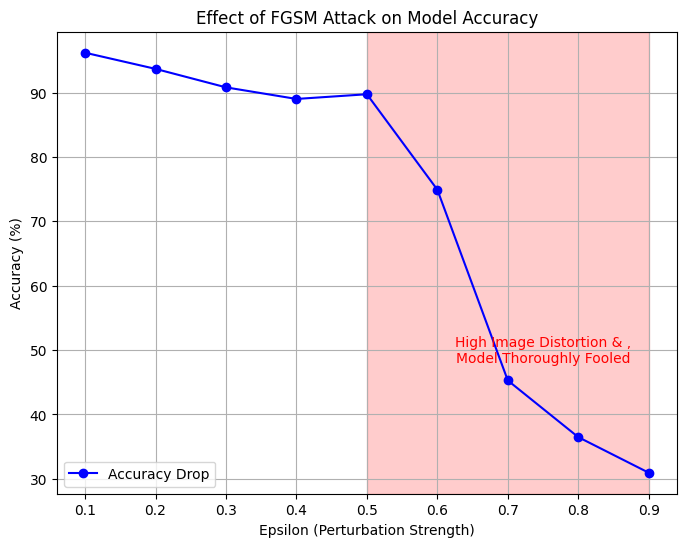

In [ ]:
import matplotlib.pyplot as plt

# Epsilon values and corresponding accuracy from our results
# Plot
plt.figure(figsize=(8, 6))
plt.plot(epsilons, accuracies, marker='o', linestyle='-', color='b', label="Accuracy Drop")

# Labels and Title
plt.xlabel("Epsilon (Perturbation Strength)")
plt.ylabel("Accuracy (%)")
plt.title("Effect of FGSM Attack on Model Accuracy")
plt.xticks(epsilons)
plt.grid(True)
plt.legend()

# Highlight distortion region (using a shaded region)
plt.axvspan(0.5, 0.9, color='red', alpha=0.2, label="Model Thoroughly Fooled")
plt.text(0.75, 50, 'High Image Distortion & ,\nModel Thoroughly Fooled', color='red', ha='center', va='center')

# Display the plot
plt.show()

In [ ]:
# Accuracy test on pgd adversarial dataset

from torch.utils.data import TensorDataset, DataLoader

epsilon_list = [0.1,0.2,0.3]
accuracies = []
num_of_steps = 40
random_start = True


for i in epsilon_list:

  adv_examples = []  # Store adversarial images
  true_labels = []   # Store true labels

  #strength of the perturbation
  epsilon = i
  alpha = (epsilon / num_of_steps)  #step size
  testloader = DataLoader(testset, batch_size=64, shuffle=False) #loading 64 imgs in a batch

  # Loop through all test batches
  for images, labels in testloader:
    #images, labels = images.to(device), labels.to(device) # Move images and labels to the device
    adv_images = pgd_attack(model, images, labels, epsilon, alpha, num_of_steps, random_start)
    adv_examples.append(adv_images)
    true_labels.append(labels.detach())

  adv_examples = torch.cat(adv_examples, dim=0)
  true_labels = torch.cat(true_labels, dim=0)

  # Wrap adversarial examples and labels in a dataset
  adv_dataset2 = TensorDataset(adv_examples, true_labels)

  # Create DataLoader for adversarial examples
  adv_testloader = DataLoader(adv_dataset2, batch_size=64, shuffle=False)
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in adv_testloader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy_adv = 100 * correct / total
  print(f'Accuracy of the model on the PGD adversarial test set with epsilon = {epsilon}: {accuracy_adv:.2f}%')
  accuracies.append(accuracy_adv)

Accuracy of the model on the PGD adversarial test set with epsilon = 0.1: 96.24%
Accuracy of the model on the PGD adversarial test set with epsilon = 0.2: 93.06%
Accuracy of the model on the PGD adversarial test set with epsilon = 0.3: 87.19%


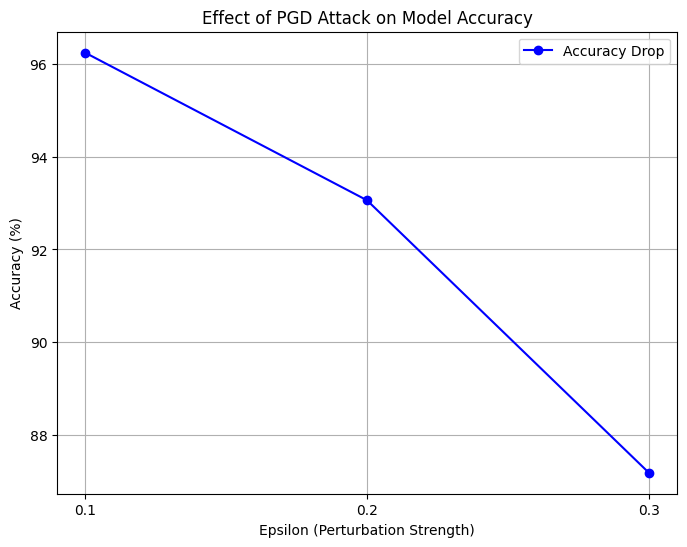

In [ ]:
import matplotlib.pyplot as plt

# Epsilon values and corresponding accuracy from our results
epsilon_list = [0.1, 0.2, 0.3]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(epsilon_list, accuracies, marker='o', linestyle='-', color='b', label="Accuracy Drop")

# Labels and Title
plt.xlabel("Epsilon (Perturbation Strength)")
plt.ylabel("Accuracy (%)")
plt.title("Effect of PGD Attack on Model Accuracy")
plt.xticks(epsilon_list)
plt.grid(True)
plt.legend()

# Highlight distortion region (using a shaded region)
#plt.axvspan(0.1, 0.2, color='red', alpha=0.2, label="Drastic Accuracy Drop")
#plt.text(0.15, 1, 'Drastic Accuracy Loss', color='red', ha='center', va='center')

# Display the plot
plt.show()